In [20]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
SimData = SimData(sim_folder)

exclude_nums = [
    20,  # broken halo
    25,  #? halo with only underdensities? look at skymap for this one...
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using Fermi-Dirac (FD) PSD

## Overdensity band

ic| tot_dens_halos.shape: (10, 50)


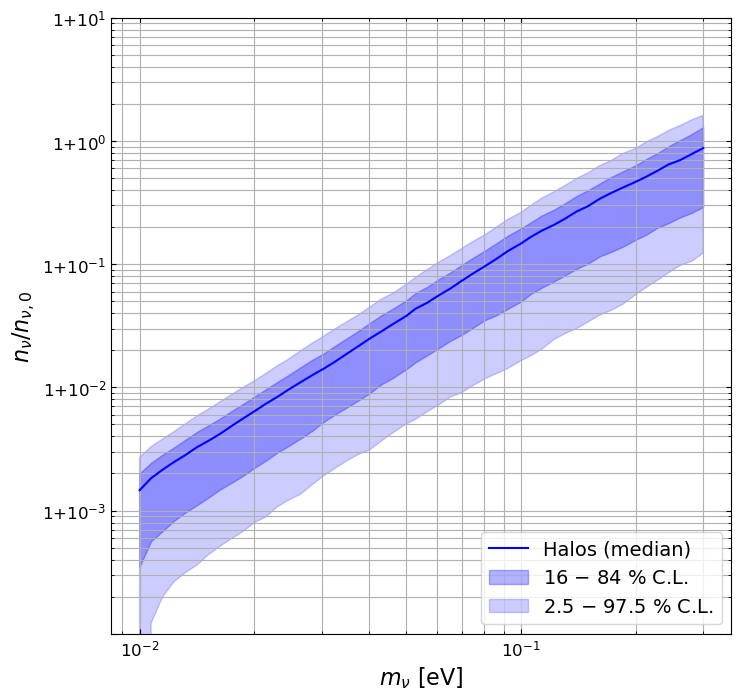

In [4]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)

SimPlot.overdensity_band(
    dens_arr=tot_dens_halos,
    m_arr=nu_mass_range,
    plot_ylims=(1e-4,1e1),
    plot_log=True,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
    args=Params())

## Anisotropy Skymaps and Power Spectra

In [5]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_mass_range,
    pix_sr=SimData.pix_sr,
    args=Params())
ic(nu_dens.shape)

ic| nu_vectors.shape: (768, 1000, 2, 6)
ic| nu_dens.shape: (50, 768)


(50, 768)

ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(0.073631, dtype=float64)
    CNB_dens_1mass.max(): Array(0.07408356, dtype=float64)


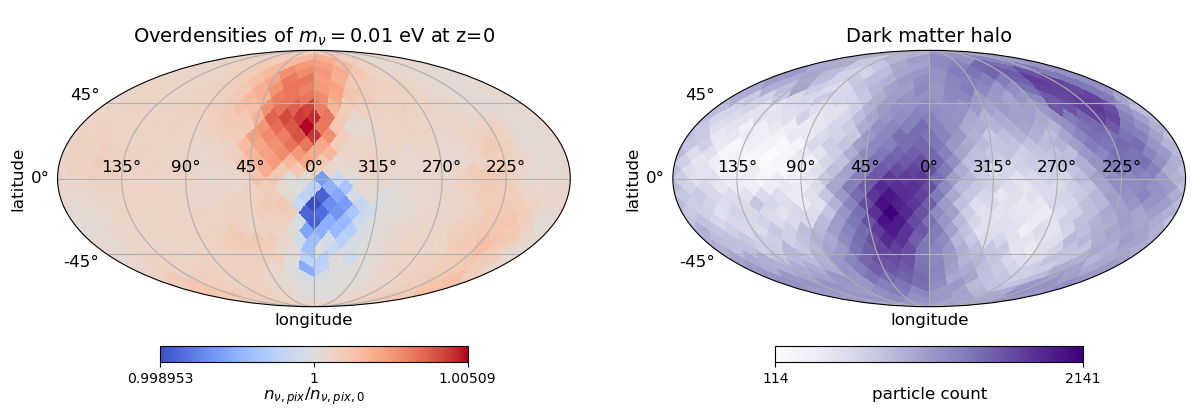

In [17]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.01
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
m_idx = jnp.abs(nu_mass_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

# Using Primordial Fluctuations (PF) PSD

## Temperature fluctuation skymaps from Cl

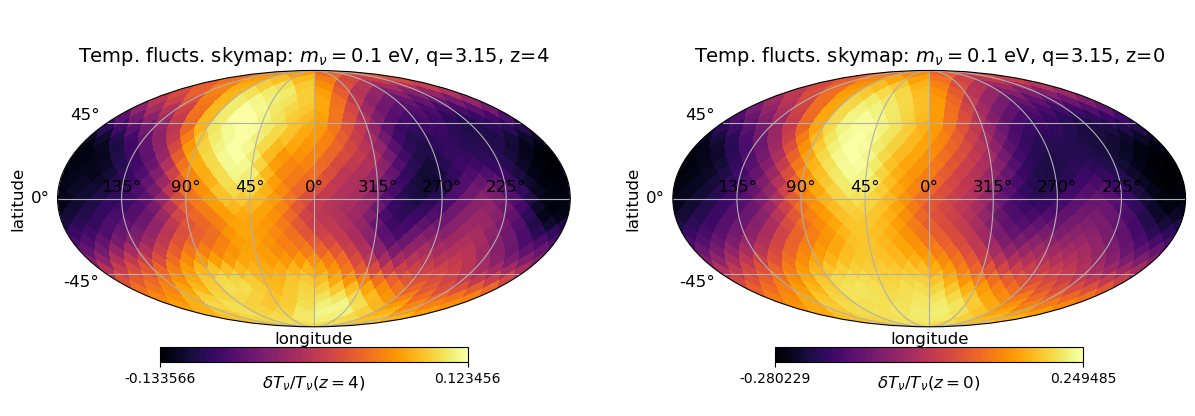

Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:
-0.1762 to 0.1578 around T_CNB


In [24]:
# Choose a neutrino mass to display
m_Cl = 0.1

# Load Cl
Cls_z4 = jnp.load(f"{Cl_folder}/Cls_z=4_m={m_Cl}eV.npy")
Cls_z0 = jnp.load(f"{Cl_folder}/Cls_z=0_m={m_Cl}eV.npy")
# (q momentum bins, l multipoles) = (50, 20)

# Add the monopole term as 0 and choose a momentum to display
Cl_qi_z4 = jnp.insert(Cls_z4, 0, 0, axis=1)[Primordial.Cl_qi, :]
Cl_qi_z0 = jnp.insert(Cls_z0, 0, 0, axis=1)[Primordial.Cl_qi, :]
# (q momentum bins, l multipoles + 1) = (50, 21)

# Create temp. flucts. skymaps from Cls, fixed with a seed
np.random.seed(5)
Tmap_z4 = hp.sphtfunc.synfast(Cl_qi_z4, nside=SimData.Nside, lmax=None, pol=False)
np.random.seed(5)  #note: seed needs to reset
Tmap_z0 = hp.sphtfunc.synfast(Cl_qi_z0, nside=SimData.Nside, lmax=None, pol=False)

# Tmaps are in micro Kelvin around T_CNB, show in Kelvin
Deltas_z4 = Tmap_z4*Primordial.uK/Params.K
Deltas_z0 = Tmap_z0*Primordial.uK/Params.K
# (Npix)

dict_z4 = dict(
    title=fr"Temp. flucts. skymap: $m_\nu={m_Cl}$ eV, q={Primordial.q_select}, z=4", 
    unit=r"$\delta T_\nu / T_\nu (z=4)$",
    cmap="inferno",
    # cmap="coolwarm",
    sub=121)

dict_z0 = dict(
    title=fr"Temp. flucts. skymap: $m_\nu={m_Cl}$ eV, q={Primordial.q_select}, z=0", 
    unit=r"$\delta T_\nu / T_\nu (z=0)$",
    cmap="inferno",
    # cmap="coolwarm",
    sub=122)

SimPlot.healpix_side_by_side(
    Deltas_z4, Deltas_z0, dict_z4, dict_z0, 
    f"{fig_folder}/Temp_flucts_skymaps.pdf", Params)


print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
TZ_val_left = -176166*Primordial.uK
TZ_val_right = 157773*Primordial.uK
print(f"{TZ_val_left/Params.K:.4f} to {TZ_val_right/Params.K:.4f} around T_CNB")

## Inspect number density files

In [26]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
ic(pix_dens_FD.shape)
ic(tot_dens_FD.shape)
print("\n")

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
ic(pix_dens_PF.shape)
ic(tot_dens_PF.shape)

# Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# ic(Deltas.shape)
print("END")

ic| pix_dens_FD.shape: (10, 50, 768)
ic| tot_dens_FD.shape: (10, 50)
ic| pix_dens_PF.shape: (10, 3, 768)
ic| tot_dens_PF.shape: (10, 3)




END


## Comparison of FD & PF skymaps

In [68]:
# Choose a halo and mass to display
halo_i = 1
m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")

m_pick = 0.1
mPF_i = jnp.abs(m_specs - m_pick).argmin()
mFD_i = jnp.abs(m_range - m_pick).argmin()

N0_pix = Params.N0 / SimData.Npix
skymap_norm = N0_pix / (Params.cm**-3)

ic| FD_skymap.sum()*N0_pix/(Params.cm**-3): Array(58.34244046, dtype=float64)


ic| PF_skymap.sum()*N0_pix/(Params.cm**-3): Array(58.24212837, dtype=float64)


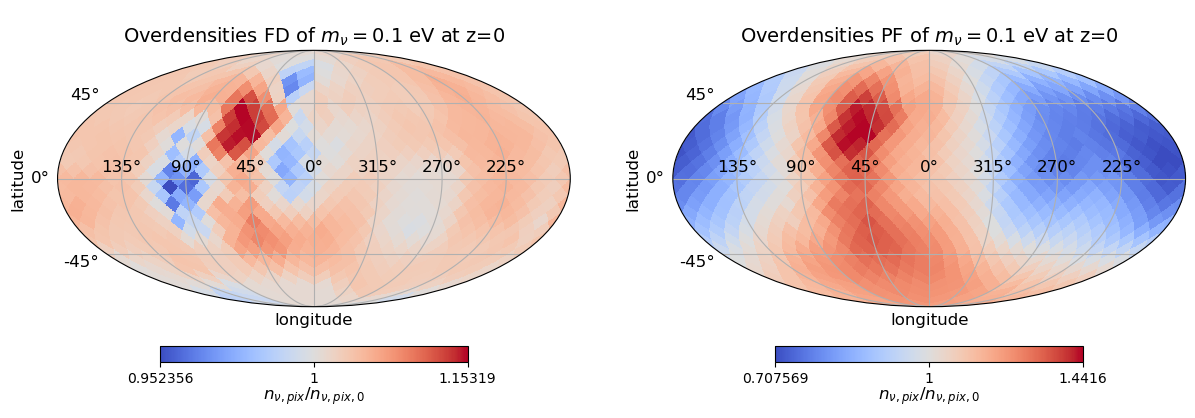

In [69]:
### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
ic(FD_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / skymap_norm
ic(PF_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)  

## Comparison of FD & PF power spectra

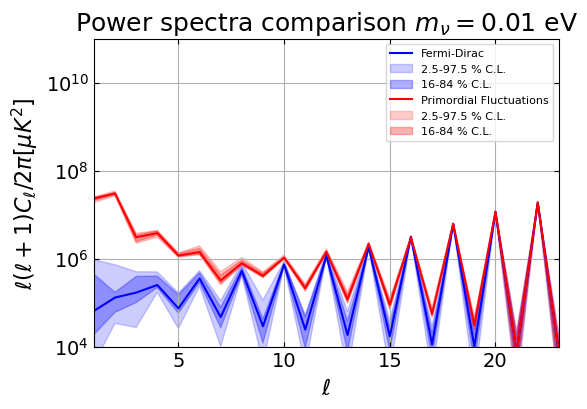

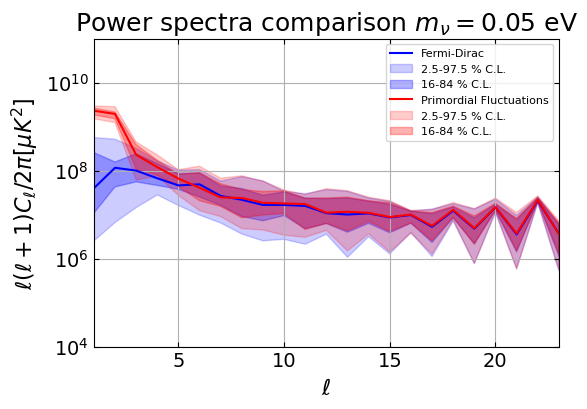

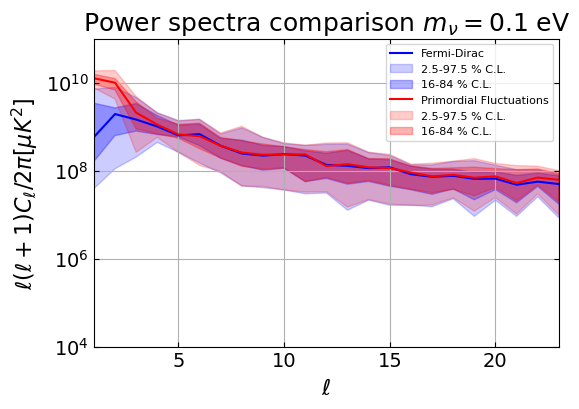

In [72]:
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder)

# Other code

In [ ]:
def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


def cartesian_to_healpix(Nside_map, xyz_pos_in, obs_pos_in):

    # Center on observer position.
    xyz_pos = xyz_pos_in - obs_pos_in
    x, y, z = xyz_pos[:,0], xyz_pos[:,1], xyz_pos[:,2]

    # Convert x,y,z to angles.
    proj_xy_plane_dis = np.sqrt(x**2 + y**2)

    thetas = np.arctan2(z, proj_xy_plane_dis)
    phis = np.arctan2(y, x)

    # To galactic latitude and longitude (in degrees) for healpy.
    hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

    # Convert angles to pixel indices using ang2pix.
    pixel_indices = hp.ang2pix(
            Nside_map, hp_glon, hp_glat, lonlat=True)

    # Create a Healpix map and increment the corresponding pixels
    healpix_map = np.zeros(hp.nside2npix(Nside_map))
    np.add.at(healpix_map, pixel_indices, 1)

    return pixel_indices, healpix_map